In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import cv2

In [52]:
# Load dataset

directory = './Vehicle/'
X_raw = []
Y_raw = []

target_size = (100, 100)
for folder in os.listdir(directory):
    
    folder_path = os.path.join(directory, folder)
    
    for file in os.listdir(folder_path):
        # print(file, folder)
        
        file_path = os.path.join(folder_path, file)
        
        image = cv2.imread(file_path)
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_gray_resized = cv2.resize(image_gray, target_size)
        
        X_raw.append(image_gray_resized)
        Y_raw.append(folder)


X_raw = np.array(X_raw)
Y_raw = np.array(Y_raw)
print(X_raw[100], Y_raw[100])

[[147 147 147 ... 147 147 147]
 [147 147 147 ... 147 147 147]
 [147 147 147 ... 147 147 147]
 ...
 [147 147 147 ... 147 147 147]
 [147 147 147 ... 147 147 147]
 [147 147 147 ... 147 147 147]] airplanes


In [3]:
print(f'X shape: {X_raw.shape} | Y shape: {Y_raw.shape}')

classes = np.unique(Y_raw)

print(f'Classes: {list(set(Y_raw))} | {classes}')

X shape: (3000, 100, 100) | Y shape: (3000,)
Classes: ['cars', 'airplanes', 'ship'] | ['airplanes' 'cars' 'ship']


In [4]:
# Normalize pixel values

X_normalized = X_raw / 255

print(f'X_normalized shape: {X_normalized.shape}')

X_normalized shape: (3000, 100, 100)


In [5]:
print((Y_raw.shape, classes.shape))

((3000,), (3,))


In [6]:
# One hot encoding

label_to_index = {label: index for index, label in enumerate(classes)}

print(label_to_index)

def one_hot_encoding(Y):
    
    Y_encoded = np.zeros((Y.shape[0], classes.shape[0]))
    for idx, y in enumerate(Y):
        
        encode_idx = label_to_index[y]
        Y_encoded[idx, encode_idx] = 1
        
    return Y_encoded
    
Y_encoded = one_hot_encoding(Y_raw)

print(Y_encoded)

{'airplanes': 0, 'cars': 1, 'ship': 2}
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [54]:
# One hot encoding (to_categorical)

label_to_index = {label: index for index, label in enumerate(classes)}

Y_numeric = [label_to_index[y] for y in Y_raw]
Y_encoded_library = tf.keras.utils.to_categorical(Y_numeric)

print(Y_encoded_library)


[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [7]:
# Train test split (80 | 10 | 10)

X_train, X_temp, Y_train, Y_temp = train_test_split(X_normalized, Y_encoded, test_size=0.2, random_state=20)
X_test, X_val, Y_test, Y_val = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=22)

print(f'X_train shape: {X_train.shape} | X_val shape: {X_val.shape} | X_test shape: {X_test.shape}')
print(f'Y_train shape: {Y_train.shape} | Y_val shape: {Y_val.shape} | X_test shape: {Y_test.shape}')

X_train shape: (2400, 100, 100) | X_val shape: (300, 100, 100) | X_test shape: (300, 100, 100)
Y_train shape: (2400, 3) | Y_val shape: (300, 3) | X_test shape: (300, 3)


In [8]:
# Adding channel for Conv2D layer

input_shape = np.expand_dims(np.zeros(target_size), axis=-1).shape
print(input_shape)

(100, 100, 1)


In [9]:
Y_train.shape

(2400, 3)

In [39]:
# Model

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_shape)), # (100, 100, 1)
    tf.keras.layers.Conv2D(8, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(12, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(classes.shape[0], activation='linear')
])

learning_rate = 0.001
epochs = 20

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',          
    monitor='val_accuracy', 
    save_best_only=True,     
    mode='max',              
)

history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs)

Epoch 1/20
75/75 [==============================] - 1s 11ms/step - loss: 0.8822 - accuracy: 0.5779 - val_loss: 0.7007 - val_accuracy: 0.7267
Epoch 2/20
75/75 [==============================] - 1s 7ms/step - loss: 0.6977 - accuracy: 0.6904 - val_loss: 0.6431 - val_accuracy: 0.7267
Epoch 3/20
75/75 [==============================] - 1s 9ms/step - loss: 0.6538 - accuracy: 0.7154 - val_loss: 0.6532 - val_accuracy: 0.7633
Epoch 4/20
75/75 [==============================] - 0s 6ms/step - loss: 0.6319 - accuracy: 0.7283 - val_loss: 0.6062 - val_accuracy: 0.7567
Epoch 5/20
75/75 [==============================] - 0s 6ms/step - loss: 0.6099 - accuracy: 0.7358 - val_loss: 0.5954 - val_accuracy: 0.7767
Epoch 6/20
75/75 [==============================] - 0s 6ms/step - loss: 0.5652 - accuracy: 0.7600 - val_loss: 0.6068 - val_accuracy: 0.7567
Epoch 7/20
75/75 [==============================] - 0s 6ms/step - loss: 0.5438 - accuracy: 0.7658 - val_loss: 0.5529 - val_accuracy: 0.7833
Epoch 8/20
75/75 [=

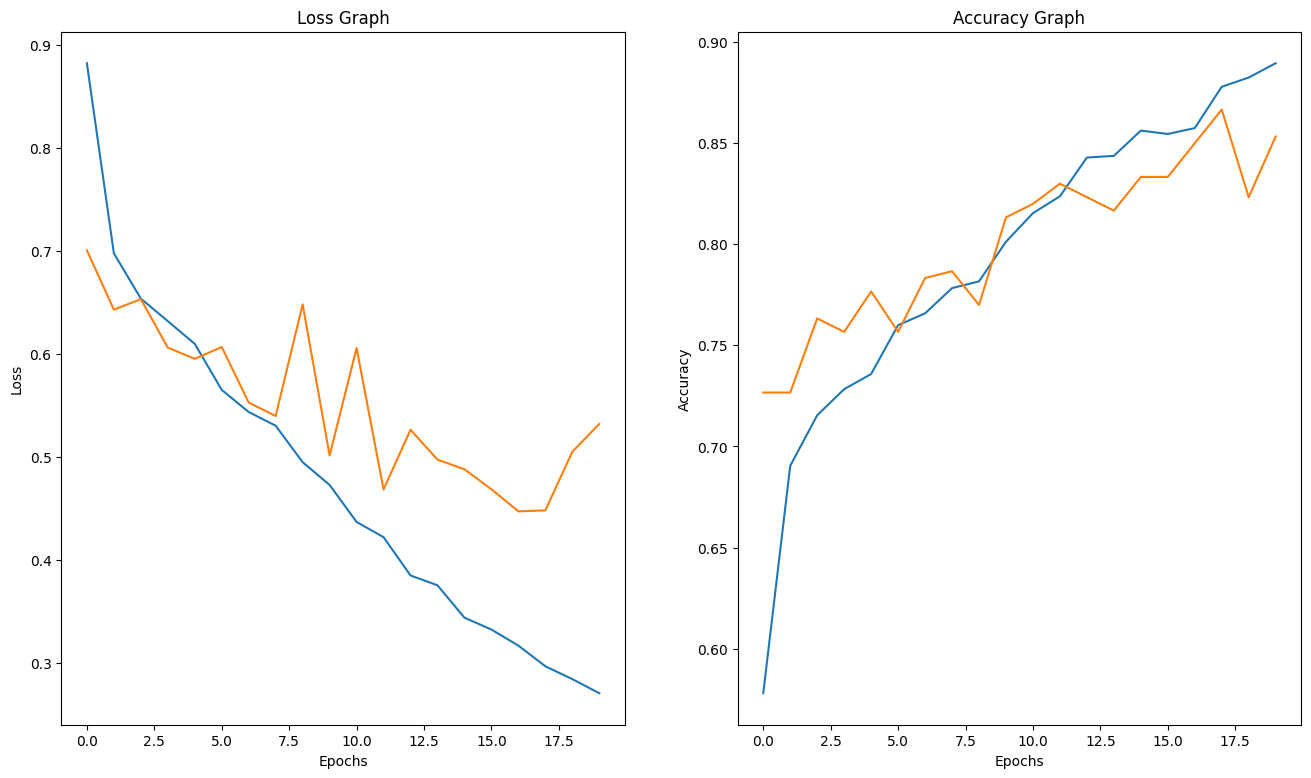

In [40]:
# Plot

plt.figure(figsize=(16, 9))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss Graph')


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Accuracy Graph')

plt.show()


In [41]:
# Evaluate with test

# BEST_MODEL_PATH = './best_model.h5'

# model = tf.keras.models.load_model(BEST_MODEL_PATH)

test_loss, test_accuracy = model.evaluate(X_test, Y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

10/10 [==============================] - 0s 4ms/step - loss: 0.4922 - accuracy: 0.8200
Test Loss: 0.492171972990036
Test Accuracy: 0.8199999928474426


10/10 [==============================] - 0s 3ms/step
Sample 0: Actual Label: 0 | Predicted Label: 1
Sample 1: Actual Label: 1 | Predicted Label: 1
Sample 2: Actual Label: 2 | Predicted Label: 2
Sample 3: Actual Label: 0 | Predicted Label: 1
Sample 4: Actual Label: 1 | Predicted Label: 1
Sample 5: Actual Label: 2 | Predicted Label: 2
Sample 6: Actual Label: 1 | Predicted Label: 1
Sample 7: Actual Label: 0 | Predicted Label: 1
Sample 8: Actual Label: 1 | Predicted Label: 1
Sample 9: Actual Label: 1 | Predicted Label: 1


Original label:
Sample 0: Actual Label: airplanes | Predicted Label: cars
Sample 1: Actual Label: cars | Predicted Label: cars
Sample 2: Actual Label: ship | Predicted Label: ship
Sample 3: Actual Label: airplanes | Predicted Label: cars
Sample 4: Actual Label: cars | Predicted Label: cars
Sample 5: Actual Label: ship | Predicted Label: ship
Sample 6: Actual Label: cars | Predicted Label: cars
Sample 7: Actual Label: airplanes | Predicted Label: cars
Sample 8: Actual Lab

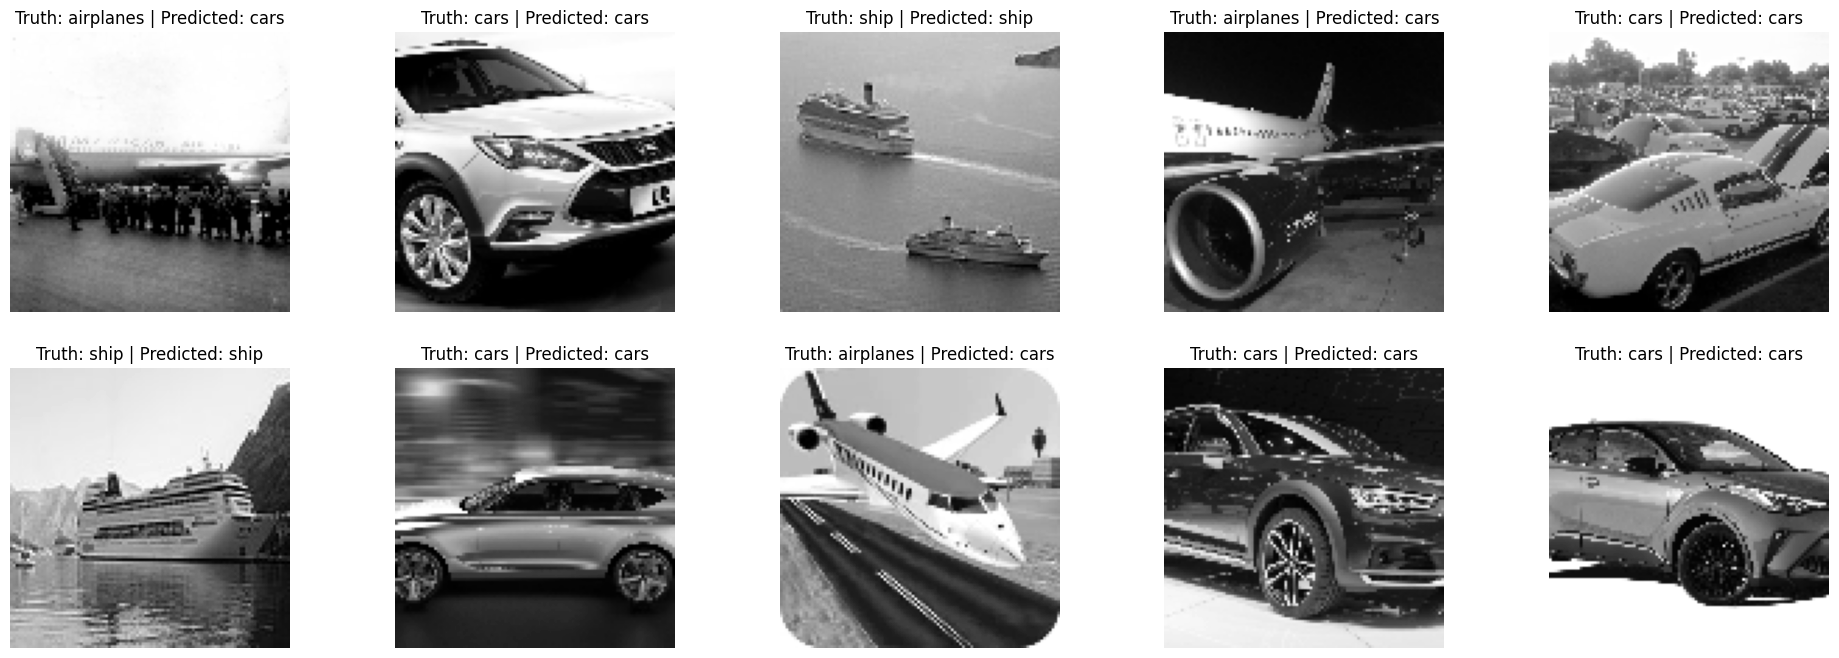

In [42]:
# Predictions

Y_raw_pred = model.predict(X_test)
Y_pred = np.argmax(Y_raw_pred, axis= 1) # Maximum index by row

n_sample = 10

random_sample_idxs = np.random.randint(0, X_test.shape[0], size=n_sample)


for idx, rand_idx in enumerate(random_sample_idxs):
    
    print(f'Sample {idx}: Actual Label: {np.argmax(Y_test[rand_idx])} | Predicted Label: {Y_pred[rand_idx]}')


print(f'\n\nOriginal label:')

# With original label
index_to_label = {index: label for index, label in enumerate(classes)}

for idx, rand_idx in enumerate(random_sample_idxs):
    
    print(f'Sample {idx}: Actual Label: {index_to_label[np.argmax(Y_test[rand_idx])]} | Predicted Label: {index_to_label[Y_pred[rand_idx]]}')
    

# Print test images with prediction   
    
plt.figure(figsize=(24, 8))

for idx, rand_idx in enumerate(random_sample_idxs):
    
    plt.subplot(2, 5, idx + 1)
    plt.imshow(X_test[rand_idx], cmap='gray')
    plt.title(f'Truth: {index_to_label[np.argmax(Y_test[rand_idx])]} | Predicted: {index_to_label[Y_pred[rand_idx]]}')
    plt.axis('off')

plt.show()